In [2]:
import pandas as pd
import re
import nltk
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

class TextClassifier(BaseEstimator, ClassifierMixin):
    """
    Clasificador de texto basado en Logistic Regression con pipeline y compatibilidad con scikit-learn.
    """
    def __init__(self, C=10):
        nltk.download('stopwords', quiet=True)
        nltk.download('wordnet', quiet=True)
        self.lemmatizer = WordNetLemmatizer()
        self.C = C
        self.pipeline = None

    def preprocess_text(self, text, stop_words):
        """
        Preprocesa un texto eliminando caracteres especiales, stopwords y aplicando lematización.
        """
        text = text.lower()
        #text = re.sub(r'[^a-zA-Z0-9!?,.;:\'"\-\s]', '', text)        
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Eliminar puntuación y caracteres especiales
        text = re.sub(r'\s+', ' ', text).strip()
        text = ' '.join([self.lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
        return text

    def fit(self, X, y):
        """
        Entrena el modelo de clasificación de texto.
        """
        stop_words = set(stopwords.words('english'))
        X = [self.preprocess_text(text, stop_words) for text in X]

        self.pipeline = Pipeline([
            ("tfidf", TfidfVectorizer(max_features=30000, ngram_range=(1, 2),min_df=5)),
            ("scaler", MaxAbsScaler()),
            ("classifier", LogisticRegression(max_iter=1000, C=self.C))
        ])
        
        self.pipeline.fit(X, y)
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        """
        Realiza predicciones en nuevos datos.
        """
        stop_words = set(stopwords.words('english'))
        X = [self.preprocess_text(text, stop_words) for text in X]
        return self.pipeline.predict(X)

In [3]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Genera y muestra la matriz de confusión.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.savefig("confusion_matrix.png")
    plt.show()

In [4]:
def train_and_save_model(train_path):
    """
    Entrena LogisticRegression y guarda el modelo.
    """
    print("-> Cargando datos de entrenamiento...")
    df_train = pd.read_csv(train_path)
    
    ros = RandomOverSampler(random_state=42)    
    X_resampled, y_resampled = ros.fit_resample(df_train[['text']], df_train['label'])
    df_train = pd.concat([X_resampled, y_resampled], axis=1)

    X_train, X_val, y_train, y_val = train_test_split(df_train["text"], df_train["label"], test_size=0.2, random_state=42, stratify=df_train["label"])
    
    print("-> Entrenando modelo de Logistic Regression...")
    model = TextClassifier(C=1)
    model.fit(X_train, y_train)

    # **Evaluación en el conjunto de entrenamiento**
    y_train_pred = model.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')

    # **Evaluación en el conjunto de validación**
    y_val_pred = model.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    print("\n >> Comparación de desempeño: <<")
    print(f"  - F1-score en entrenamiento: {train_f1:.4f}")
    print(f"  - F1-score en validación: {val_f1:.4f}")

    # 📌 Reporte de Clasificación
    print("\n📊 Reporte de Clasificación en Validación:")
    print(classification_report(y_val, y_val_pred))

    plot_confusion_matrix(y_val, y_val_pred, labels=np.unique(y_train))

    # 📌 Guardar modelo
    with open("best_model.pkl", "wb") as f:
        pickle.dump(model, f)
    
    print("> Modelo guardado como 'best_model.pkl' <")


In [5]:
from pandas import DataFrame

def predict_with_saved_model(test_path) -> pd.DataFrame:
    """
    Carga el modelo guardado y realiza predicciones en nuevos datos
    """
    print("-> Cargando modelo guardado...")
    with open("best_model.pkl", "rb") as f:
        best_model = pickle.load(f)

    print("-> Cargando datos de prueba...")
    df_test = pd.read_csv(test_path)

    df_test["Label"] = best_model.predict(df_test["text"])

    df_test.to_csv("submission.csv", index=False)
    print(">> Predicciones guardadas en 'submission.csv' <<")
    
    return df_test




-> Cargando datos de entrenamiento...
-> Entrenando modelo de Logistic Regression...

 >> Comparación de desempeño: <<
  - F1-score en entrenamiento: 0.9859
  - F1-score en validación: 0.9474

📊 Reporte de Clasificación en Validación:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      5219
           1       0.93      0.92      0.92      5219
           2       0.93      0.96      0.95      5219
           3       0.96      0.99      0.98      5220
           4       0.98      1.00      0.99      5219

    accuracy                           0.95     26096
   macro avg       0.95      0.95      0.95     26096
weighted avg       0.95      0.95      0.95     26096



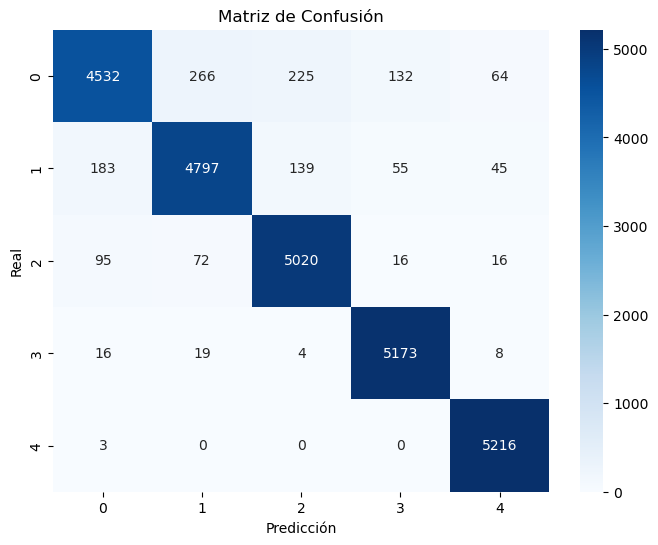

> Modelo guardado como 'best_model.pkl' <


In [6]:
train_and_save_model("data/train.csv")

In [7]:
df= predict_with_saved_model("data/data_test.csv")
df

-> Cargando modelo guardado...
-> Cargando datos de prueba...
>> Predicciones guardadas en 'submission.csv' <<


,ID,text,Label
0,1,'Henry Beller was for many years toast-master ...,2
1,2,"You have a brother; you know it, and\nhim.\nTh...",4
2,3,"Come, come; say\nyou wouldn’t.”\n“Well, then,”...",0
3,4,"'What, Sammy!'\nexclaimed the father.\n'What, ...",0
4,5,He\nlaughed heartily at my feeble portrait of ...,0
...,...,...,...
5110,5111,"I’ll to England.\nTo Ireland, I.\nOur separate...",4
5111,5112,250: _to_] F1.\n_by_ F2 F3 F4.\n_Keep_] _Sleep...,4
5112,5113,"Here come two noble beasts in, a man and a lio...",4
5113,5114,Therefore I have entreated him along\nWith us ...,4
